Author(s): Piyush Amitabh

Details: this code visualizes tracks using coordinates from df_super (generated from analysis_n_linking) and overlays them on stitched mip (generated from batch process codes)

Created: June 20, 2023

License: GNU GPL v3.0

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage

In [50]:
from natsort import natsorted
import configparser
import tifffile as tiff
from tqdm import tqdm

In [3]:
## Helping Functions

#finds stats of the passed np array
def find_stats(arr):
    print(f'Mean    {np.mean(arr):.2f}')
    print(f'Median  {np.median(arr):.2f}')
    print(f'Std     {np.std(arr):.2f}')
    print(f'COV     {(np.std(arr)/np.mean(arr)):0.2f}')
    print(f'Min     {np.min(arr):.2f}')
    print(f'Max     {np.max(arr):.2f}\n')
    return()

#removes dir and non-image(tiff) files from a list
def remove_non_image_files(big_list, root_path):
    small_list = []
    for val in big_list:
        if os.path.isfile(os.path.join(root_path, val)): #file check
            filename_list = val.split('.')
            # og_name = filename_list[0] 
            ext = filename_list[-1] 
            if (ext=="tif" or ext=="tiff" or ext=="png"): #img check
                small_list.append(val)
    return small_list

#removes dir and non-csv files from a list
def remove_non_csv_files(big_list, root_path):
    small_list = []
    for val in big_list:
        if os.path.isfile(os.path.join(root_path, val)): #file check
            filename_list = val.split('.')
            og_name = filename_list[0] 
            ext = filename_list[-1] 
            if (ext=="csv"): #csv check
                small_list.append(val)
    return small_list

#correct the file list ordering
def reorder_files_by_pos_tp(file_list):
    ordered_file_list = []
    for tp in range(1, (len(file_list)//pos_max) + 1):
        for pos in range(1, pos_max+1):
            for file_name in file_list: #find the location in img_list with pos and tp
                if (f'pos{pos}_' in file_name.casefold()) and (f'timepoint{tp}_' in file_name.casefold()):
                    ordered_file_list.append(file_name)
    return(ordered_file_list)

#finds the target file nearest to the start_path
def find_nearest_target_file(target, start_path):
    '''finds nearest target file to the 'start_path' in the dir structure
    returns the location of the found file'''
    while True:
        if os.path.isfile(os.path.join(start_path,target)):
            #found
            print(f'found {target} at:'+start_path)
            found_path = os.path.join(start_path,target)
            break

        if os.path.dirname(start_path)==start_path: #reached root
            #not found
            print(f"Error: Can't find {target}, Enter manually")
            found_path = input('Enter complete path (should end with .txt): ')
            break    
        start_path=os.path.dirname(start_path)
    return(found_path)

# User input

In [75]:
stitched_mip_dir = r'F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\gfp_mip\gfp_offset_corrected\gfp_ofc_stitched'
df_super = pd.read_csv(r'F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\GFP_region_props_ofc\linking_results\df_super_sever_gfp.csv',  index_col=[0, 1])

In [76]:
df_super.head()

track_id     area  time_point  equivalent_diameter_area  pixel_offset-1  \
1 0         1  17610.0           0                 32.279013             0.0   
  1         1  12945.0           1                 29.131833             3.0   
  2         1  16477.0           2                 31.571351            -3.0   
  3         1  17136.0           3                 31.986762            11.0   
  4         1  11309.0           4                 27.848931            12.0   

     pixel_offset-2  intensity_mean  user_surface_area  sphericity  pos  \
1 0             0.0    16680.088164        4966.150391    0.659129    1   
  1            -9.0    17655.840373        3656.382080    0.729179    1   
  2           -28.0    17595.673101        4626.180664    0.676883    1   
  3           -13.0    15594.853211        5107.635742    0.629319    1   
  4           -27.0    18167.540692        3357.888184    0.725606    1   

        x-dv-um     y-ap-um    z-lr-um     x-dv-px     y-ap-px    z-lr-px  \
1 0  163.258648  164.520067  82.877634  251.167150  253.107796  82.877634   
  1  165.268201  168.494890  82.217390  254.258770  259.222907  82.217390   
  2  162.463074  168.074922  80.234658  249.943191  258.576803  80.234658   
  3  164.374389  154.491041  81.031318  252.883676  237.678524  81.031318   
  4  172.625716  158.004112  79.558642  265.578024  243.083250  79.558642   

     distance_um  
1 0     4.502604  
  1     3.460684  
  2    13.740801  
  3     9.088170  
  4    12.182401

In [77]:
pos_max = df_super['pos'].max() #pos indexing starts from 1
# tp_max = df_super['time_point'].max() + 1 #tp indexing starts from 0

# Single image test

In [78]:
findscope_flag = 1 #KLA LSM

In [90]:
stack_full = skimage.io.imread(r'F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\gfp_mip\gfp_offset_corrected\gfp_ofc_stitched\Timepoint72_GFP_stitched.png')
# stack_full = tiff.imread(r'F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\gfp_mip\fish1_pos1_zstack_GFP_timepoint1_ds_mip.tif')
# stack_full = tiff.imread(r'F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\gfp_mip\gfp_offset_corrected\fish1_pos1_zstack_GFP_timepoint1_ds_mip.tif')


c:\Users\rpbio\anaconda3\envs\image_analysis\Lib\site-packages\imageio\plugins\pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


do following transformation:

df_super global coords -> local coords using stage pos from notes.txt -> global coords of stitching

In [93]:
main_dir = r'F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1'

#very general and robust code which looks for the files with those names instead of depending upon just the folder names
#csv files
gfp_dfsuper_flag, rfp_dfsuper_flag = False, False #0 means not found, 1 mean found
gfp_dfsuper_path, rfp_dfsuper_path = '', ''
#make a list of all 2D img files by channel to get a sample image to find scope and downscaling factor
gfp_flag, rfp_flag = False, False #0 means not found, 1 means found
gfp_mip_stitch_path, rfp_mip_stitch_path = '', ''
gfp_mip_stitch_imglist, rfp_mip_stitch_imglist = [], []

for root, subfolders, filenames in os.walk(main_dir):
    for filename in filenames:
        # print(f'Reading: {filename}')
        filepath = os.path.join(root, filename)
        # print(f'Reading: {filepath}')
        filename_list = filename.split('.')
        og_name = filename_list[0] #first of list=name
        ext = filename_list[-1] #last of list=extension

        # find csv with 'super_sever' - df_super regionprop table and 'ofc' - offset corrected
        # if (ext=="csv") and ('df_super_sever' in og_name.casefold()) and ('_ofc' in root.casefold()):
        if (ext=="csv") and ('df_super' in og_name.casefold()) and (not 'sever' in og_name.casefold())\
            and ('_ofc' in root.casefold()):#test with non-sever
        
                if (not gfp_dfsuper_flag) and ('gfp' in og_name.casefold()):
                    print('GFP df_super offset corrected found at: '+filepath)
                    gfp_dfsuper_path = filepath
                    gfp_dfsuper_flag = True
                elif (not rfp_dfsuper_flag) and ('rfp' in og_name.casefold()):
                    print('RFP df_super offset corrected found at: '+filepath)
                    rfp_dfsuper_path = filepath
                    rfp_dfsuper_flag = True
        if (ext=="tif" or ext=="tiff" or ext=="png") and ('mip' in root.casefold()) and ('stitched' in root.casefold()):
            if (not gfp_flag) and ('gfp' in og_name.casefold()):
                print('GFP Stitched MIP images found at: '+root)
                gfp_mip_stitch_path = root
                gfp_mip_stitch_imglist = remove_non_image_files(natsorted(os.listdir(root)), root)
                gfp_flag = True
            elif (not rfp_flag) and ('rfp' in og_name.casefold()):
                print('RFP Stitched MIP images found at: '+root)
                rfp_mip_stitch_path = root
                rfp_mip_stitch_imglist = remove_non_image_files(natsorted(os.listdir(root)), root)
                rfp_flag = True
# if not gfp_dfsuper_flag:
#     print(f'No GFP regionprop offset corrected csv found in {main_dir}')
# if not rfp_dfsuper_flag:
#     print(f'No RFP regionprop offset corrected csv found in {main_dir}')
if not gfp_flag:
    print(f'No GFP MIP images found in {main_dir}')
if not rfp_flag:
    print(f'No RFP MIP images found in {main_dir}')

GFP Stitched MIP images found at: F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\gfp_mip\gfp_offset_corrected\gfp_ofc_stitched
GFP df_super offset corrected found at: F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\GFP_region_props_ofc\linking_results\df_super_sever_gfp.csv
RFP Stitched MIP images found at: F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\RFP\rfp_mip\rfp_offset_corrected\rfp_ofc_stitched
RFP df_super offset corrected found at: F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\RFP\RFP_region_props_ofc\linking_results\df_super_sever_rfp.csv


In [94]:
if (gfp_dfsuper_flag ^ gfp_flag) or (rfp_dfsuper_flag ^ rfp_flag):
    print("ERROR: Something wrong with finding MIPs and df_super")
    print("exiting..")
    exit()

In [95]:
#find the nearest notes.txt
config = configparser.ConfigParser()
start_path = ''
# img = np.zeros((1,1)) #dummy
#get start_path for search
#get sample image to find scope and downscaling factor
if gfp_flag:
    start_path = gfp_mip_stitch_path
    # img = tiff.imread(os.path.join(gfp_mip_stitch_path, gfp_mip_stitch_imglist[0]))
elif rfp_flag:
    start_path = rfp_mip_stitch_path
    # img = tiff.imread(os.path.join(rfp_mip_stitch_path, rfp_mip_stitch_imglist[0]))
#find the fish number from the image path
fish_num = int(start_path[start_path.casefold().rfind('fish')+len('fish')]) #find fish number starting from the child dir
print(f'Found fish_num = {fish_num}')
user_check = input('Continue if correct? (y-default/n)') or 'y'
if user_check.casefold()=='n':
    fish_num = int(input('Enter fish_num: '))

target1 = 'notes.txt'
target2 = 'Notes.txt'
while True:
    if os.path.isfile(os.path.join(start_path,target1)):
        #found
        print(f'found {target1} at:'+start_path)
        config.read(os.path.join(start_path,target1))
        break
    elif os.path.isfile(os.path.join(start_path,target2)):
        #found
        print(f'found {target2} at:'+start_path)
        config.read(os.path.join(start_path,target2))
        break

    if os.path.dirname(start_path)==start_path: #reached root
        #not found
        print("Error: Can't find notes.txt, Enter manually")
        notes_path = input('Enter complete path (should end with .txt): ')
        config.read(notes_path)
        break    
    start_path=os.path.dirname(start_path)
# print(config.sections())

abbrev = config.getfloat(f"Fish {fish_num} Region 1", "x_pos", fallback=False)
if (abbrev):
    # print('abbreviated')
    config_prop_list = ["x_pos", "y_pos", "z_pos"]
else:
    # print('not abbreviated')
    config_prop_list = ["x_position", "y_position", "z_position"]
stage_coords = np.zeros(shape=(pos_max,3))
for i in range(1, pos_max+1):
    for j, val in enumerate(config_prop_list): #x/y/z axes
        stage_coords[i-1][j] = config.getfloat(f"Fish {fish_num} Region {i}", val)
print(f"Found stage_coords: \n{stage_coords}")

(ds_h, ds_w) = (4,4)# find_lsm_scope(img.shape[0], img.shape[1])
# The pixel spacing in our LSM image is 1µm in the z axis, and  0.1625µm in the x and y axes.
zd, xd, yd = 1, 0.1625, 0.1625 #zeroth dimension is z in skimage coords
orig_spacing = np.array([zd, xd, yd]) #change to the actual pixel spacing from the microscope
new_spacing = np.array([zd, xd*ds_w, yd*ds_h]) #downscale x&y by n

Found fish_num = 1
found notes.txt at:F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled
Found stage_coords: 
[[-10569.  -4246.  -2495.]
 [-10569.  -3916.  -2514.]
 [-10534.  -3586.  -2534.]
 [-10495.  -3256.  -2472.]]


In [96]:
#get original coordinates before shifting to global coords
def global_coordinate_changer(stage_coords):
    ''' accept stage_coords read from notes.txt to stitch images
        Returns: 2D np.array same shape as stage_coords
    '''
    stage_origin = stage_coords[0].copy()
    global_coords_um = stage_coords - stage_origin #set first stage position as zero
    if findscope_flag==0:
        print("ERROR: Couldn't find the LSM scope")
        exit()
    elif findscope_flag==1: #KLA LSM
        global_coords_um[:, 0] = global_coords_um[:, 0] * -1 #flip x axis
    elif findscope_flag==2: #WIL LSM
        global_coords_um[:, [1,0]] = global_coords_um[:, [0,1]]#swap x and y axis = 1st and 2nd columns
    else:
        print('Error: Findscope_flag not found.. exiting.')
        exit()
    #um to pixels: 1px = (1/pixel width) um
    #as the stage position is in x (col:axis-2), y(row:axis-1), z(plane:axis-0) format
    global_coords_px = global_coords_um/ [new_spacing[2], new_spacing[1], new_spacing[0]]
    return(global_coords_px)

In [97]:
global_coords_px = global_coordinate_changer(stage_coords)
global_coords_px

array([[  -0.        ,    0.        ,    0.        ],
       [  -0.        ,  507.69230769,  -19.        ],
       [ -53.84615385, 1015.38461538,  -39.        ],
       [-113.84615385, 1523.07692308,   23.        ]])

In [98]:
df=df_super.copy()

In [99]:
for j in range(pos_max):
    df.loc[df.pos==j+1, 'y-ap-px-local']= df['y-ap-px'] - global_coords_px[j][1] #y stage
    df.loc[df.pos==j+1, 'x-dv-px-local']= df['x-dv-px'] - global_coords_px[j][0] #x stage

In [100]:
def new_global_shift(stage_coords, df):
    ''' accept a list of 2D images in img_list and use stage_coords read from notes.txt to stitch images
        Returns: 2D np.array containing the stitched image
    '''
    if findscope_flag==0:
        print("ERROR: Couldn't find the LSM scope")
        exit()
    elif findscope_flag==1: #call kla_stitch
        kla_2d_global_shift(stage_coords, df)
    elif findscope_flag==2: #call wil stitch
        wil_2d_global_shift(stage_coords, df)

def wil_2d_global_shift(stage_coords, df): 
    stage_origin = stage_coords[0].copy()
    global_coords_um = stage_coords - stage_origin
    global_coords_um[:, [1,0]] = global_coords_um[:, [0,1]]#swap x and y axis = 1st and 2nd columns

    #we only care about x and y, so get rid of last column
    #um to pixels: 1px = (1/pixel width) um
    # global_coords_px_xoffset = (np.ceil(global_coords_um[:, :-1] / 0.65)).astype(int) #has first img as origin

    global_coords_px_xoffset1 = (np.ceil(global_coords_um[:, 0] / new_spacing[1])).astype(int) #has first img as origin - xoffset
    global_coords_px_xoffset2 = (np.ceil(global_coords_um[:, 1] / new_spacing[2])).astype(int)
    global_coords_px_xoffset = np.vstack((global_coords_px_xoffset1, global_coords_px_xoffset2)).T
    
    #stitching along x, so choose img with minimum y as the new origin 
    y_offset_origin = np.argmin(global_coords_px_xoffset, axis=0)[1] #axis-0 is columnwise
    global_coords_px_yoffset = global_coords_px_xoffset - global_coords_px_xoffset[y_offset_origin] #change origin to min y img
    # y is height of the image which means it is the rows in the image
    for i in range(pos_max):
        x0 = global_coords_px_xoffset[i, 0] #ith row and 1st column in global coords
        y0 = global_coords_px_yoffset[i, 1]
        df.loc[df.pos==i+1, 'y-ap-px-global']= df['y-ap-px-local'] + y0 #y stage
        df.loc[df.pos==i+1, 'x-dv-px-global']= df['x-dv-px-local'] + x0 #x stage

def kla_2d_global_shift(stage_coords, df):
    stage_origin = stage_coords[0].copy()
    global_coords_um = stage_coords - stage_origin
    global_coords_um[:, 0] = global_coords_um[:, 0] * -1 #flip x axis
    
    #we only care about x and y, so get rid of last column
    #um to pixels: 1px <-> 0.65um use downscaling factor
    # global_coords_px_yoffset = (np.ceil(global_coords_um[:, :-1] / 0.65)).astype(int) #has first img as origin - yoffset

    global_coords_px_yoffset1 = (np.ceil(global_coords_um[:, 0] / new_spacing[1])).astype(int) #has first img as origin - yoffset
    global_coords_px_yoffset2 = (np.ceil(global_coords_um[:, 1] / new_spacing[2])).astype(int)
    global_coords_px_yoffset = np.vstack((global_coords_px_yoffset1, global_coords_px_yoffset2)).T
    
    #stitching along y, so choose img with minimum x to find x-offset
    x_offset_origin = np.argmin(global_coords_px_yoffset, axis=0)[0] #axis-0 is columnwise
    global_coords_px_xoffset = global_coords_px_yoffset - global_coords_px_yoffset[x_offset_origin] #change origin to min x img
    # y is height of the image which means it is the rows in the image
    for i in range(pos_max):
        x0 = global_coords_px_xoffset[i, 0] #ith row and 1st column in global coords
        y0 = global_coords_px_yoffset[i, 1]
        df.loc[df.pos==i+1, 'y-ap-px-global'] = df['y-ap-px-local'] + y0 #y stage
        df.loc[df.pos==i+1, 'x-dv-px-global'] = df['x-dv-px-local'] + x0 #x stage        

In [101]:
new_global_shift(stage_coords, df)

In [102]:
df

track_id     area  time_point  equivalent_diameter_area  \
1   0         1  17610.0           0                 32.279013   
    1         1  12945.0           1                 29.131833   
    2         1  16477.0           2                 31.571351   
    3         1  17136.0           3                 31.986762   
    4         1  11309.0           4                 27.848931   
...         ...      ...         ...                       ...   
393 0       393   4909.0          78                 21.086191   
    1       393   3565.0          79                 18.953393   
394 0       394  10995.0          78                 27.588761   
    1       394   7778.0          79                 24.582333   
395 0       395   1591.0          78                 14.484067   

       pixel_offset-1  pixel_offset-2  intensity_mean  user_surface_area  \
1   0             0.0             0.0    16680.088164        4966.150391   
    1             3.0            -9.0    17655.840373        3656.382080   
    2            -3.0           -28.0    17595.673101        4626.180664   
    3            11.0           -13.0    15594.853211        5107.635742   
    4            12.0           -27.0    18167.540692        3357.888184   
...               ...             ...             ...                ...   
393 0            35.0            30.0     3223.580694        2280.000244   
    1            31.0            26.0     6806.553892        1444.566406   
394 0            35.0            30.0     8855.428769        3336.155518   
    1            31.0            26.0    13531.188810        2416.253418   
395 0            35.0            30.0     2322.271527        1313.678833   

       sphericity  pos  ...     y-ap-um    z-lr-um     x-dv-px      y-ap-px  \
1   0    0.659129    1  ...  164.520067  82.877634  251.167150   253.107796   
    1    0.729179    1  ...  168.494890  82.217390  254.258770   259.222907   
    2    0.676883    1  ...  168.074922  80.234658  249.943191   258.576803   
    3    0.629319    1  ...  154.491041  81.031318  252.883676   237.678524   
    4    0.725606    1  ...  158.004112  79.558642  265.578024   243.083250   
...           ...  ...  ...         ...        ...         ...          ...   
393 0    0.612648    3  ...  818.276724  18.610427  256.109559  1258.887268   
    1    0.781243    3  ...  826.715850  13.155242  268.678042  1271.870538   
394 0    0.716750    3  ...  875.374692  17.561579  257.838644  1346.730295   
    1    0.785694    3  ...  914.450715  16.905617  259.444714  1406.847254   
395 0    0.501697    3  ...  725.487925  17.135264  307.227367  1116.135269   

         z-lr-px  distance_um  y-ap-px-local  x-dv-px-local  y-ap-px-global  \
1   0  82.877634     4.502604     253.107796     251.167150      253.107796   
    1  82.217390     3.460684     259.222907     254.258770      259.222907   
    2  80.234658    13.740801     258.576803     249.943191      258.576803   
    3  81.031318     9.088170     237.678524     252.883676      237.678524   
    4  79.558642    12.182401     243.083250     265.578024      243.083250   
...          ...          ...            ...            ...             ...   
393 0  18.610427    12.950631     243.502653     309.955712     1259.502653   
    1  13.155242          NaN     256.485922     322.524196     1272.485922   
394 0  17.561579    39.095469     331.345680     311.684798     1347.345680   
    1  16.905617          NaN     391.462638     313.290868     1407.462638   
395 0  17.135264          NaN     100.750654     361.073521     1116.750654   

       x-dv-px-global  
1   0      364.167150  
    1      367.258770  
    2      362.943191  
    3      365.883676  
    4      378.578024  
...               ...  
393 0      369.955712  
    1      382.524196  
394 0      371.684798  
    1      373.290868  
395 0      421.073521  

[2891 rows x 21 columns]

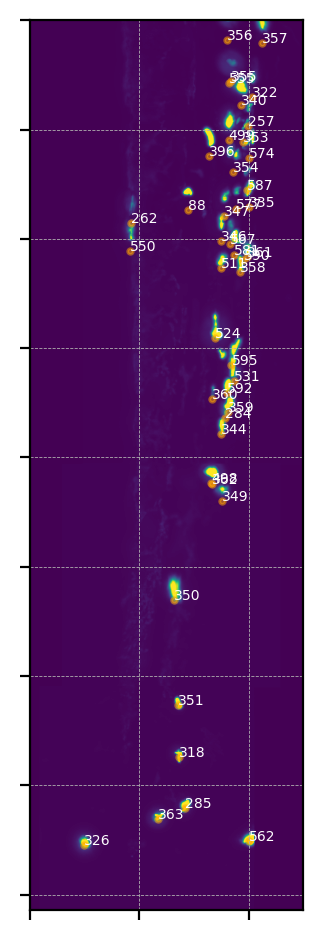

In [135]:
df_sel = df[df.time_point==71]

x_list = df_sel['x-dv-px-global'].to_list()
y_list = df_sel['y-ap-px-global'].to_list()
# y_list = df['y'].to_list()

fig, ax = plt.subplots(dpi=200)
ax.scatter(x_list, y_list, alpha=0.5, color='orange', s=4)
for i, t_id in enumerate(df_sel.track_id):
    ax.annotate(t_id, (x_list[i], y_list[i]), color='w', fontsize=5)

# fig.gca().invert_yaxis()
# ax.imshow(stack_full)
# test_img = skimage.exposure.adjust_log(stack_full, gain=10)

vmin, vmax = np.percentile(stack_full, q=(0.1, 99.5))
test_img = skimage.exposure.rescale_intensity(
    stack_full,
    in_range=(vmin, vmax),
    out_range=np.float32
)

# test_img = skimage.exposure.equalize_hist(stack_full)
# test_img = skimage.exposure.adjust_gamma(stack_full, gamma=0.5)
# test_img = skimage.exposure.adjust_log(stack_full, gain=20)

ax.imshow(test_img)
plt.grid(True, linestyle='--', linewidth=0.3)
ax.get_xaxis().set_ticklabels([])
ax.get_yaxis().set_ticklabels([])
# ax.imshow(stack_full)
fig.tight_layout()
plt.show()

# Batchprocess

processes all images in a given folder (main_dir)

In [85]:
main_dir = r'F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1'

In [86]:
findscope_flag = 1 #KLA LSM

In [87]:
#very general and robust code which looks for the files with those names instead of depending upon just the folder names
#csv files
gfp_dfsuper_flag, rfp_dfsuper_flag = False, False #0 means not found, 1 mean found
gfp_dfsuper_path, rfp_dfsuper_path = '', ''
#make a list of all 2D img files by channel to get a sample image to find scope and downscaling factor
gfp_flag, rfp_flag = False, False #0 means not found, 1 means found
gfp_mip_stitch_path, rfp_mip_stitch_path = '', ''
gfp_mip_stitch_imglist, rfp_mip_stitch_imglist = [], []

for root, subfolders, filenames in os.walk(main_dir):
    for filename in filenames:
        # print(f'Reading: {filename}')
        filepath = os.path.join(root, filename)
        # print(f'Reading: {filepath}')
        filename_list = filename.split('.')
        og_name = filename_list[0] #first of list=name
        ext = filename_list[-1] #last of list=extension

        # find csv with 'super_sever' - df_super regionprop table and 'ofc' - offset corrected
        if (ext=="csv") and ('df_super' in og_name.casefold()) \
            and (not 'sever' in og_name.casefold()) and ('_ofc' in root.casefold()):#test with non-sever
        # if (ext=="csv") and ('df_super_sever' in og_name.casefold()) and ('_ofc' in root.casefold()):
                if (not gfp_dfsuper_flag) and ('gfp' in og_name.casefold()):
                    print('GFP df_super offset corrected found at: '+filepath)
                    gfp_dfsuper_path = filepath
                    gfp_dfsuper_flag = True
                elif (not rfp_dfsuper_flag) and ('rfp' in og_name.casefold()):
                    print('RFP df_super offset corrected found at: '+filepath)
                    rfp_dfsuper_path = filepath
                    rfp_dfsuper_flag = True
        if (ext=="tif" or ext=="tiff" or ext=="png") and ('mip' in root.casefold()) and ('stitched' in root.casefold()):
            if (not gfp_flag) and ('gfp' in og_name.casefold()):
                print('GFP Stitched MIP images found at: '+root)
                gfp_mip_stitch_path = root
                gfp_mip_stitch_imglist = remove_non_image_files(natsorted(os.listdir(root)), root)
                gfp_flag = True
            elif (not rfp_flag) and ('rfp' in og_name.casefold()):
                print('RFP Stitched MIP images found at: '+root)
                rfp_mip_stitch_path = root
                rfp_mip_stitch_imglist = remove_non_image_files(natsorted(os.listdir(root)), root)
                rfp_flag = True
# if not gfp_dfsuper_flag:
#     print(f'No GFP regionprop offset corrected csv found in {main_dir}')
# if not rfp_dfsuper_flag:
#     print(f'No RFP regionprop offset corrected csv found in {main_dir}')
if not gfp_flag:
    print(f'No GFP MIP images found in {main_dir}')
if not rfp_flag:
    print(f'No RFP MIP images found in {main_dir}')

GFP Stitched MIP images found at: F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\gfp_mip\gfp_offset_corrected\gfp_ofc_stitched
GFP df_super offset corrected found at: F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\GFP\GFP_region_props_ofc\linking_results\df_super_gfp.csv
RFP Stitched MIP images found at: F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\RFP\rfp_mip\rfp_offset_corrected\rfp_ofc_stitched
RFP df_super offset corrected found at: F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled\fish1\RFP\RFP_region_props_ofc\linking_results\df_super_rfp.csv


In [88]:
if (gfp_dfsuper_flag ^ gfp_flag) or (rfp_dfsuper_flag ^ rfp_flag):
    print("ERROR: Something wrong with finding MIPs and df_super")
    print("exiting..")
    exit()

In [89]:
#get pos_max
if gfp_flag:
    df = pd.read_csv(gfp_dfsuper_path, index_col=[0,1])
elif rfp_flag:
    df = pd.read_csv(rfp_dfsuper_path, index_col=[0,1])

pos_max = df['pos'].max() #pos indexing starts from 1


In [90]:
#find the nearest notes.txt
config = configparser.ConfigParser()
start_path = ''
# img = np.zeros((1,1)) #dummy
#get start_path for search
#get sample image to find scope and downscaling factor
if gfp_flag:
    start_path = gfp_mip_stitch_path
    # img = tiff.imread(os.path.join(gfp_mip_stitch_path, gfp_mip_stitch_imglist[0]))
elif rfp_flag:
    start_path = rfp_mip_stitch_path
    # img = tiff.imread(os.path.join(rfp_mip_stitch_path, rfp_mip_stitch_imglist[0]))
#find the fish number from the image path
fish_num = int(start_path[start_path.casefold().rfind('fish')+len('fish')]) #find fish number starting from the child dir
print(f'Found fish_num = {fish_num}')
user_check = input('Continue if correct? (y-default/n)') or 'y'
if user_check.casefold()=='n':
    fish_num = int(input('Enter fish_num: '))

target1 = 'notes.txt'
target2 = 'Notes.txt'
while True:
    if os.path.isfile(os.path.join(start_path,target1)):
        #found
        print(f'found {target1} at:'+start_path)
        config.read(os.path.join(start_path,target1))
        break
    elif os.path.isfile(os.path.join(start_path,target2)):
        #found
        print(f'found {target2} at:'+start_path)
        config.read(os.path.join(start_path,target2))
        break

    if os.path.dirname(start_path)==start_path: #reached root
        #not found
        print("Error: Can't find notes.txt, Enter manually")
        notes_path = input('Enter complete path (should end with .txt): ')
        config.read(notes_path)
        break    
    start_path=os.path.dirname(start_path)
# print(config.sections())

abbrev = config.getfloat(f"Fish {fish_num} Region 1", "x_pos", fallback=False)
if (abbrev):
    # print('abbreviated')
    config_prop_list = ["x_pos", "y_pos", "z_pos"]
else:
    # print('not abbreviated')
    config_prop_list = ["x_position", "y_position", "z_position"]
stage_coords = np.zeros(shape=(pos_max,3))
for i in range(1, pos_max+1):
    for j, val in enumerate(config_prop_list): #x/y/z axes
        stage_coords[i-1][j] = config.getfloat(f"Fish {fish_num} Region {i}", val)
print(f"Found stage_coords: \n{stage_coords}")

(ds_h, ds_w) = (4,4)# find_lsm_scope(img.shape[0], img.shape[1])
# The pixel spacing in our LSM image is 1µm in the z axis, and  0.1625µm in the x and y axes.
zd, xd, yd = 1, 0.1625, 0.1625 #zeroth dimension is z in skimage coords
orig_spacing = np.array([zd, xd, yd]) #change to the actual pixel spacing from the microscope
new_spacing = np.array([zd, xd*ds_w, yd*ds_h]) #downscale x&y by n

Found fish_num = 1
found notes.txt at:F:\Caudal Fin Cut_ds\time lapse_04_18_23_day_downsampled
Found stage_coords: 
[[-10569.  -4246.  -2495.]
 [-10569.  -3916.  -2514.]
 [-10534.  -3586.  -2534.]
 [-10495.  -3256.  -2472.]]


---

In [91]:
def stage_global_coord_changer(stage_coords):
    ''' accept stage_coords read from notes.txt to stitch images
        Returns: 2D np.array same shape as stage_coords
    '''
    stage_origin = stage_coords[0].copy()
    global_coords_um = stage_coords - stage_origin #set first stage position as zero
    if findscope_flag==0:
        print("ERROR: Couldn't find the LSM scope")
        exit()
    elif findscope_flag==1: #KLA LSM
        global_coords_um[:, 0] = global_coords_um[:, 0] * -1 #flip x axis
    elif findscope_flag==2: #WIL LSM
        global_coords_um[:, [1,0]] = global_coords_um[:, [0,1]]#swap x and y axis = 1st and 2nd columns
    else:
        print('Error: Findscope_flag not found.. exiting.')
        exit()
    #um to pixels: 1px = (1/pixel width) um
    #as the stage position is in x (col:axis-2), y(row:axis-1), z(plane:axis-0) format
    global_coords_px = global_coords_um/ [new_spacing[2], new_spacing[1], new_spacing[0]]
    return(global_coords_px)

In [92]:
def new_global_shift(stage_coords, df):
    ''' accept a list of 2D images in img_list and use stage_coords read from notes.txt to stitch images
        Returns: 2D np.array containing the stitched image
    '''
    if findscope_flag==0:
        print("ERROR: Couldn't find the LSM scope")
        exit()
    elif findscope_flag==1: #call kla_stitch
        kla_2d_global_shift(stage_coords, df)
    elif findscope_flag==2: #call wil stitch
        wil_2d_global_shift(stage_coords, df)

def wil_2d_global_shift(stage_coords, df): 
    stage_origin = stage_coords[0].copy()
    global_coords_um = stage_coords - stage_origin
    global_coords_um[:, [1,0]] = global_coords_um[:, [0,1]]#swap x and y axis = 1st and 2nd columns

    #we only care about x and y, so get rid of last column
    #um to pixels: 1px = (1/pixel width) um
    # global_coords_px_xoffset = (np.ceil(global_coords_um[:, :-1] / 0.65)).astype(int) #has first img as origin

    global_coords_px_xoffset1 = (np.ceil(global_coords_um[:, 0] / new_spacing[1])).astype(int) #has first img as origin - xoffset
    global_coords_px_xoffset2 = (np.ceil(global_coords_um[:, 1] / new_spacing[2])).astype(int)
    global_coords_px_xoffset = np.vstack((global_coords_px_xoffset1, global_coords_px_xoffset2)).T
    
    #stitching along x, so choose img with minimum y as the new origin 
    y_offset_origin = np.argmin(global_coords_px_xoffset, axis=0)[1] #axis-0 is columnwise
    global_coords_px_yoffset = global_coords_px_xoffset - global_coords_px_xoffset[y_offset_origin] #change origin to min y img
    # y is height of the image which means it is the rows in the image
    for i in range(pos_max):
        x0 = global_coords_px_xoffset[i, 0] #ith row and 1st column in global coords
        y0 = global_coords_px_yoffset[i, 1]
        df.loc[df.pos==i+1, 'y-ap-px-global']= df['y-ap-px-local'] + y0 #y stage
        df.loc[df.pos==i+1, 'x-dv-px-global']= df['x-dv-px-local'] + x0 #x stage

def kla_2d_global_shift(stage_coords, df):
    stage_origin = stage_coords[0].copy()
    global_coords_um = stage_coords - stage_origin
    global_coords_um[:, 0] = global_coords_um[:, 0] * -1 #flip x axis
    
    #we only care about x and y, so get rid of last column
    #um to pixels: 1px <-> 0.65um use downscaling factor
    # global_coords_px_yoffset = (np.ceil(global_coords_um[:, :-1] / 0.65)).astype(int) #has first img as origin - yoffset

    global_coords_px_yoffset1 = (np.ceil(global_coords_um[:, 0] / new_spacing[1])).astype(int) #has first img as origin - yoffset
    global_coords_px_yoffset2 = (np.ceil(global_coords_um[:, 1] / new_spacing[2])).astype(int)
    global_coords_px_yoffset = np.vstack((global_coords_px_yoffset1, global_coords_px_yoffset2)).T
    
    #stitching along y, so choose img with minimum x to find x-offset
    x_offset_origin = np.argmin(global_coords_px_yoffset, axis=0)[0] #axis-0 is columnwise
    global_coords_px_xoffset = global_coords_px_yoffset - global_coords_px_yoffset[x_offset_origin] #change origin to min x img
    # y is height of the image which means it is the rows in the image
    for i in range(pos_max):
        x0 = global_coords_px_xoffset[i, 0] #ith row and 1st column in global coords
        y0 = global_coords_px_yoffset[i, 1]
        df.loc[df.pos==i+1, 'y-ap-px-global'] = df['y-ap-px-local'] + y0 #y stage
        df.loc[df.pos==i+1, 'x-dv-px-global'] = df['x-dv-px-local'] + x0 #x stage        

In [93]:
# tp_max = df_super['time_point'].max() + 1 #tp indexing starts from 0

def global_coord_transformer(df_super):
        df = df_super.copy(deep=True)
        #get local coordinates before shifting to global coords
        global_coords_px = stage_global_coord_changer(stage_coords)
        for j in range(pos_max):
                df.loc[df.pos==j+1, 'y-ap-px-local']= df['y-ap-px'] - global_coords_px[j][1] #y stage
                df.loc[df.pos==j+1, 'x-dv-px-local']= df['x-dv-px'] - global_coords_px[j][0] #x stage
        #now shift to new global coords using same method as stitched image
        new_global_shift(stage_coords, df)
        return(df)        

In [94]:
def overlay_n_save(ch_name, timepoint, stitched_img, save_path):
    """Description: this function uses df_transformed to find the coords and track_id 
    and overlays that info on the MIP

    Saves the overlaid image at save_path
    """
    df_sel = df_transformed[df_transformed.time_point==timepoint]

    x_list = df_sel['x-dv-px-global'].to_list()
    y_list = df_sel['y-ap-px-global'].to_list()

    fig, ax = plt.subplots()
    ax.scatter(x_list, y_list, alpha=0.5, color='orange', s=4)
    for i, t_id in enumerate(df_sel.track_id):
        ax.annotate(t_id, (x_list[i], y_list[i]), color='w', fontsize=5)

    ax.imshow(skimage.exposure.adjust_gamma(stitched_img, gamma=0.5)) #gamma adjustment
    plt.grid(True, linestyle='--', linewidth=0.3)
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    fig.tight_layout()
    fig.savefig(os.path.join(save_path,f'{ch_name}_overlaid_tp_{timepoint+1}.png'), dpi=500, bbox_inches='tight')
    # plt.show()
    plt.close(fig)

In [95]:
#read all images per timepoint then overlay and save them at dest 
ch_flag_list = [gfp_flag, rfp_flag]
sub_names = ['GFP', 'RFP']
ch_mip_path_list = [gfp_mip_stitch_path, rfp_mip_stitch_path]
ch_img_list = [gfp_mip_stitch_imglist, rfp_mip_stitch_imglist]
ch_dfsuper_path_list = [gfp_dfsuper_path, rfp_dfsuper_path]

for k, ch_flag in enumerate(ch_flag_list):
    ch_name = sub_names[k]
    ch_mip_path = ch_mip_path_list[k]
    all_img_list = ch_img_list[k]
    csv_path = ch_dfsuper_path_list[k]

    if ch_flag:
        print(f"Overlay {ch_name} images...")
        #read df_super for given channel
        df_super = pd.read_csv(csv_path, index_col=[0, 1])
        #transform global coords of df_super
        df_transformed = global_coord_transformer(df_super)

        #save dir
        save_path = os.path.join(ch_mip_path, ch_name.casefold()+'_overlaid_tid')
        if not os.path.exists(save_path): #check if the dest exists
            print("Save path doesn't exist.")
            os.makedirs(save_path)
            print(f"Directory '{ch_name.casefold()}_overlaid_tid' created")
        else:
            print("Save path exists")

        for tp_val, img_name in tqdm(enumerate(all_img_list)): #sorted by ascending order timepoint
            #read stitched image
            stitched_img = skimage.io.imread(os.path.join(ch_mip_path, img_name))
            overlay_n_save(ch_name, timepoint=tp_val, stitched_img=stitched_img, save_path=save_path)

Overlay GFP images...
Save path doesn't exist.
Directory 'gfp_overlaid_tid' created


0it [00:00, ?it/s]c:\Users\rpbio\anaconda3\envs\image_analysis\Lib\site-packages\imageio\plugins\pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(
80it [01:00,  1.32it/s]


Overlay RFP images...
Save path doesn't exist.
Directory 'rfp_overlaid_tid' created


0it [00:00, ?it/s]c:\Users\rpbio\anaconda3\envs\image_analysis\Lib\site-packages\imageio\plugins\pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(
80it [01:12,  1.11it/s]


---